# FINN - Folding
--------------------------------------
**Note: To run this notebook, you first need to run the build flow in the 3rd cybersecurity notebook as we utilize one of the intermediate models generated in that process in this notebook.** 

This notebook describes the use of FINN parallelization parameters (PE & SIMD) to efficiently streamline models so as to extract the maximum performance out of them.

We'll use the utility function `showInNetron()` to visualize and interact with our network in the Jupyter Notebook and `showSrc()` to show source code of FINN library calls.

In [1]:
from finn.util.visualization import showInNetron, showSrc

Note: The build_flow in the cybsec_mlp notebook comprises a transformation step `step_target_fps_parallelization` that automatically sets custom parallelization parameters needed to achieve a given `target_fps` by invoking the [`SetFolding` transformation](https://github.com/Xilinx/finn/blob/main/src/finn/transformation/fpgadataflow/set_folding.py#L46).

More details of the above step can be found [here](https://github.com/Xilinx/finn/blob/main/src/finn/builder/build_dataflow_steps.py#L394).

This notebook shows the manual version of this step and explains how these attributes can improve performance and what are their effects on resource utilization for developers who need to maximize the performance of their network. 

For that we will use the `step_convert_to_hls.onnx` file as starting point. This intermediate model from the cybersecurity example is the model representation after the high-level ONNX layers are converted to HLS layers. Each node in the graph now corresponds to an HLS C++ function call and the parallelization parameters can be set using the node attributes.

We will take this model to show how to set the folding factors manually and analyze the estimated execution clock cycles and the resource utilization of each layer in the network.

### FINN-style Dataflow Architectures <a id='dataflow_arch'></a>

We start with a quick recap of FINN-style dataflow architectures. The key idea in such architectures is to parallelize across layers as well as within layers by dedicating a proportionate amount of compute resources to each layer, as illustrated in the figure below.

![](finn-dataflow.png)

In practice, the layers are instantiated by function calls to optimized Vitis HLS building blocks from the [finn-hlslib](https://github.com/Xilinx/finn-hlslib) library.

Since each layer will be instantiated, we can flexibly set the parallelization of each layer and thus control resources and throughput of our network, as visualized in the imaged below:

![](finn-folding.png)

# Part-1 : Loading the ONNX model.

As discussed above, the network needs to go through a few preparation steps before it can be fed into our estimation functions.

The `.onnx` file loaded here is taken from the cybersecurity end2end example notebook. 
We pick the onnx file `step_convert_to_hls.onnx` to which the necessary transformations have been applied for this notebook (Network layers mapped to necessary FINN-HLS blocks. In this case, the `MatrixVectorActivation` Units). 

To interact with the `.onnx` file we use the `ModelWrapper()`. This wrapper simplifies the access to different model attributes and allows us to apply custom transformations on the model.

In the below cell, we load our onnx file and view the cybersecurity MLP network in Netron.

In [2]:
from qonnx.core.modelwrapper import ModelWrapper
model = ModelWrapper("../end2end_example/cybersecurity/output_estimates_only/intermediate_models/step_convert_to_hls.onnx")
model.save("step_convert_to_hls.onnx")

showInNetron("step_convert_to_hls.onnx")

Serving 'step_convert_to_hls.onnx' at http://0.0.0.0:5920


# Part 2 : Parallelization Parameters: PE & SIMD

The computational parallelism can be varied by setting the folding factors or also called parallelization parameters **PE** and **SIMD** of each layer. These parallelization attributes are subject to certain constraints and should be selected accordingly.

To see more details about how this is implemented in the `MatrixVectorActivation` layer (MVAU), please have a look at [this documentation](https://github.com/Xilinx/finn/blob/github-pages/docs/finn-sheduling-and-folding.pptx). A schematic of the folding in an MVAU for a fully-connected layer is shown below:

![](finn-folding-mvau.png)

In the case of the MVAU, `PE` & `SIMD` are subject to the following constraints: 

If `MW` is the number of input features and `MH` the number of output features:

        MW % SIMD == 0
        MH % PE == 0
        
Total folding in the case of the MVAU is defined as:

    Total folding = (MH/PE) x (MW/SIMD)

In a streaming dataflow architecture like it is in FINN designs the throughput is determined by the slowest layer. So, the goal of adjusting these parameters is to get an almost balanced pipeline i.e. equalizing the throughput rate of layers in the generated dataflow architecture.

The FINN compiler provides analysis passes to facilitate the exploration of the folding factors of each layer. In this notebook we will show how to use these functions and explore how the parallelization parameters affect the clock cycles and the resource utilization of the generated dataflow architecture.

We start with a naive case where `PE` & `SIMD` values across all layers are 1, this is the starting point of our exploration and is also the state the network is in after the conversion to HLS layers. If you take a look at the model using Netron and click on one of the MVAU layers, you can see that `PE` and `SIMD` are both set to 1 by default.

In [3]:
showInNetron("step_convert_to_hls.onnx")

Stopping http://0.0.0.0:5920
Serving 'step_convert_to_hls.onnx' at http://0.0.0.0:5920


We import the analysis passes  (`exp_cycles_per_layer()`) and  (`res_estimation()`) to estimate the number of clock cycles and resource utilization of each network layer.

In [4]:
from finn.analysis.fpgadataflow.exp_cycles_per_layer import exp_cycles_per_layer
from finn.analysis.fpgadataflow.res_estimation import res_estimation

Analysis passes in FINN return information about the model in form of a dictionary, you can learn more about analysis passes in general in this Jupyter notebook: [0_custom_analysis_pass.ipynb](0_custom_analysis_pass.ipynb).

We start by calling the analysis pass `exp_cycles_per_layer()`, which returns a dictionary with the layer names as keys and the expected cycles as values. Afterwards, we plot the result in a block diagram.

In [5]:
cycles_dict = model.analysis(exp_cycles_per_layer)
cycles_dict

{'MatrixVectorActivation_0': 38400,
 'MatrixVectorActivation_1': 4096,
 'MatrixVectorActivation_2': 4096,
 'MatrixVectorActivation_3': 64}

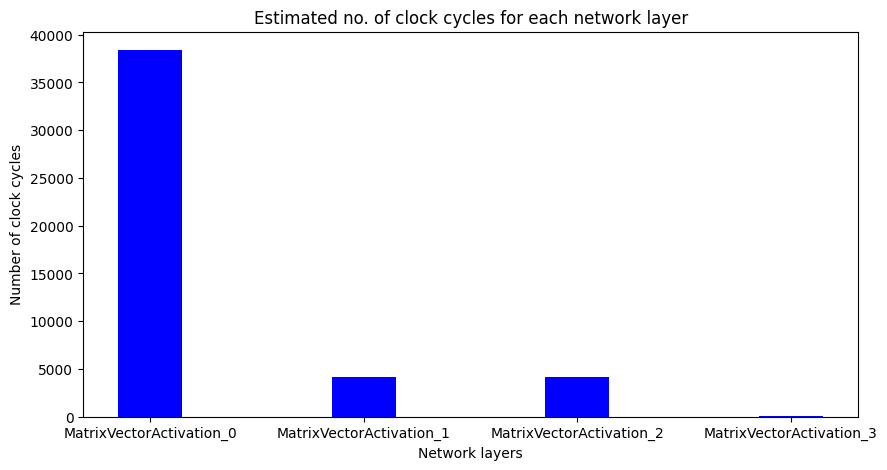

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10, 5))
plt.bar(cycles_dict.keys(), cycles_dict.values(), color ='blue', width = 0.3)
plt.xlabel("Network layers")
plt.ylabel("Number of clock cycles")
plt.title("Estimated no. of clock cycles for each network layer")
plt.show()

We observe that the bottleneck in the execution of the model on hardware would come from the execution of the first layer which takes estimated 38400 clock cycles to execute one set of its inputs.

No matter how quickly the other layers execute, the throughput will be defined by the first layer's execution latency.

Let's have a look now at the estimated resources per layer by calling another analysis pass.
The keys are again the layer names, but the values are now a dictionary with the resource estimates per layer.

In [8]:
res_dict = model.analysis(res_estimation)
res_dict

{'MatrixVectorActivation_0': {'BRAM_18K': 5,
  'BRAM_efficiency': 0.8333333333333334,
  'LUT': 319,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'MatrixVectorActivation_1': {'BRAM_18K': 1,
  'BRAM_efficiency': 0.4444444444444444,
  'LUT': 320,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'MatrixVectorActivation_2': {'BRAM_18K': 1,
  'BRAM_efficiency': 0.4444444444444444,
  'LUT': 320,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'MatrixVectorActivation_3': {'BRAM_18K': 1,
  'BRAM_efficiency': 0.006944444444444444,
  'LUT': 320,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0}}

Next to the absolute numbers of LUTs, BRAM, URAM and DSPs, the analysis pass also provides information about the efficiency of the memory usage. If the memory type is not utilized, the efficiency is by default 1. You can see that above for the `URAM_efficiency`. In all other cases the efficiency indicates the actual parameter storage needed divided by the allocated BRAM/URAM storage. So, this means in our example MVAU_0 uses 5 block ram and they are 83% utilized. 

After we extract that information from the model, we plot the number of LUTs. In this notebook we concentrate on the influence on the LUT usage, but by manipulating the code below, you can also extract information about memory and dsp usage.

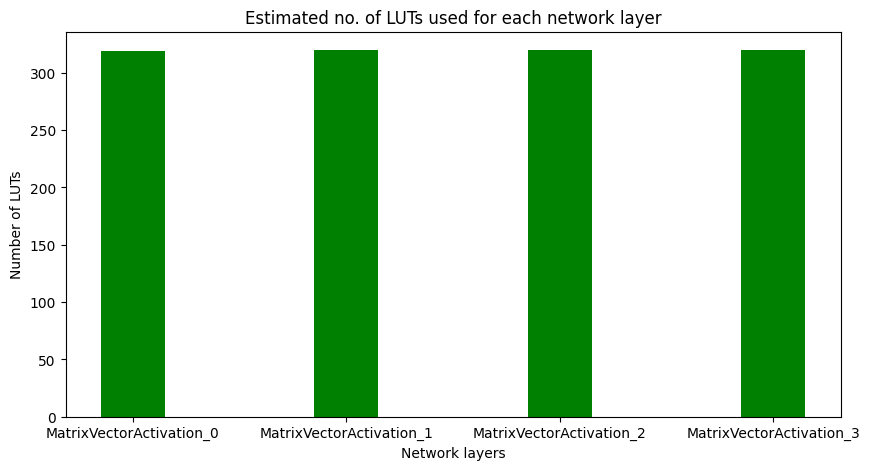

In [13]:
# Extracting LUTs from res_dict
LUTs = [res_dict[key]["LUT"] for key in res_dict.keys()]   

#Plotting the bar graph of each network layer with their corresponding LUT resource utilization
fig = plt.figure(figsize = (10, 5))
plt.bar(res_dict.keys(), LUTs, color ='green', width = 0.3)
plt.xlabel("Network layers")
plt.ylabel("Number of LUTs")
plt.title("Estimated no. of LUTs used for each network layer")
plt.show()

Since we identified above that the first layer takes the highest number of cycles to complete the execution, we will now try to adjust the folding parameters to reduce its latency at the expense of an increase in resource utilization.

# QuickNote : StreamingDataWidthConverter Layer

In [37]:
fc_layers = model.get_nodes_by_op_type("MatrixVectorActivation")
for fcl in fc_layers:
    fcl_inst = getCustomOp(fcl)
    print('Instream Width =',(fcl_inst.get_instream_width()),'Outstream Width =',int(fcl_inst.get_outstream_width()))

Instream Width = 1 Outstream Width = 2
Instream Width = 2 Outstream Width = 2
Instream Width = 2 Outstream Width = 2
Instream Width = 2 Outstream Width = 1


We can also view the `instream_width` and `outstream_width` of each layer using the `get_instream_width()` and `get_outstream_width()` helper functions. These widths are of particular importance as for a (balanced pipeline?) these width's should be the same.

For example, the outwidth of a given layer of the network should match the inwidth of the next layer for the (pipeline to be stable?). If they are not the same then the FINN compiler adds an extra `streamingdatawidthconverter` (which increases the overall resource utilization of the design slightly) layer to make sure these widths match.

Note, that if these widths are the same then even if we call the `InsertDWC()` transformation on our model (responsible for adding the above layer), the datawidth conversion layers will not be a part of our model as shown in the below cells. 

<div class="alert alert-block alert-warning">
<b>Question</b> in the first and the second line of the above cell.
</div>

In [11]:
from finn.transformation.fpgadataflow.insert_dwc import InsertDWC
model = model.transform(InsertDWC())

In [12]:
model.save("./cybsec_DWC_not_inserted.onnx")
showInNetron("./cybsec_DWC_not_inserted.onnx",localhost_url='xirxlabs53')#localhost_url='xirxlabs60'

Stopping http://0.0.0.0:5901
Serving './cybsec_DWC_not_inserted.onnx' at http://0.0.0.0:5901


In [13]:
#To view the source code of the matrix vector activation function
from finn.custom_op.fpgadataflow.matrixvectoractivation import MatrixVectorActivation
showSrc(MatrixVectorActivation)

class MatrixVectorActivation(HLSCustomOp):
    """Class that corresponds to finn-hls Matrix_Vector_Activate(_Stream)_Batch
    function."""

    def __init__(self, onnx_node):
        super().__init__(onnx_node)
        self.decoupled_wrapper = templates.decoupled_wrapper

    def get_nodeattr_types(self):
        my_attrs = {
            "PE": ("i", True, 0),
            "SIMD": ("i", True, 0),
            "MW": ("i", True, 0),
            "MH": ("i", True, 0),
            "resType": ("s", False, "lut", {"auto", "lut", "dsp"}),
            "ActVal": ("i", False, 0),
            # FINN DataTypes for inputs, weights, outputs
            "inputDataType": ("s", True, ""),
            "weightDataType": ("s", True, ""),
            "outputDataType": ("s", True, ""),
            # FINN DataType for accumulator -- auto-computed and updated
            "accDataType": ("s", False, "INT32"),
            # use xnor-popcount for binary weights/inputs, thus treating them
            # as bipolar
  

## Modify Parameters

We now modify the parallelization attributes of the first network layer to reduce its overall latency.
We now individually extract the `MatrixVectorActivation` blocks from the onnx file and set the config values manually (although this can be done automatically by Vivado tools also as mentioned in the introduction).

In the first step, we set the `PE` & `SIMD` values for all the layers to be '1' to establish a baseline and measure the estimated clock cycles and resource utilization for each of the individual layers.

We utilize from (`getCustomOp()`) as the helper function to set different properties of the node. The (`set_nodeattr()`) function within this function call helps us set these values.

In [14]:
fc_layers = model.get_nodes_by_op_type("MatrixVectorActivation") 
# (PE, SIMD, in_fifo_depth, out_fifo_depth, ramstyle) for each layer
config = [
    (2, 5, [16], [64], "block"),
    (1, 1, [64], [64], "auto"),#8,8
    (1, 1, [64], [64], "auto"),#8,8
    (1, 1, [64], [1], "distributed"),
]
for fcl, (pe, simd, ififo, ofifo, ramstyle) in zip(fc_layers, config):
    fcl_inst = getCustomOp(fcl)
    fcl_inst.set_nodeattr("PE", pe)
    fcl_inst.set_nodeattr("SIMD", simd)
    fcl_inst.set_nodeattr("inFIFODepths", ififo)
    fcl_inst.set_nodeattr("outFIFODepths", ofifo)
    fcl_inst.set_nodeattr("ram_style", ramstyle)
    num_inp_vec = fcl_inst.get_nodeattr("numInputVectors")

We again save the model and view it. On expanding the first `MatrixVectorActivation` we can view the updated `PE` & `SIMD` parameters for that layer.

In [16]:
model.save("./cybsec_PE_SIMD_modified.onnx")
showInNetron("./cybsec_PE_SIMD_modified.onnx",localhost_url='xirxlabs53')

Stopping http://0.0.0.0:5901
Serving './cybsec_PE_SIMD_modified.onnx' at http://0.0.0.0:5901


From the above total folding formula, we have reduced the total folding of our layer from `600 x 64` to `120 x 32`. Hence, resulting in an estimated `10x` decrease in the execution latency of our layer. 
This can be observed in the new estimated clock cycles.

In [17]:
cycles_dict_updated = []
cycles_dict_updated = exp_cycles_per_layer(model)

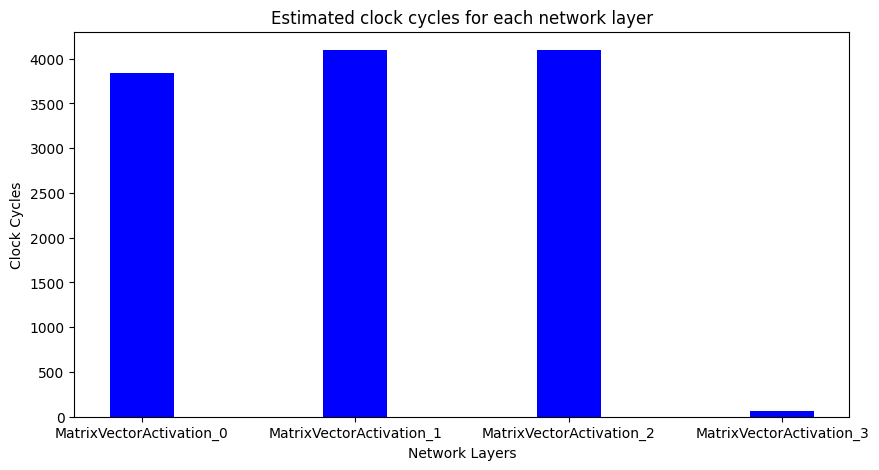

In [18]:
layers_updated = list(cycles_dict_updated.keys())
cycles_updated = list(cycles_dict_updated.values())
fig = plt.figure(figsize = (10, 5))
plt.bar(layers_updated, cycles_updated, color ='blue', width = 0.3)
plt.xlabel("Network Layers")
plt.ylabel("Clock Cycles")
plt.title("Estimated clock cycles for each network layer")
plt.show()

In [19]:
res_dict_updated = model.analysis(res_estimation)
res_dict_updated

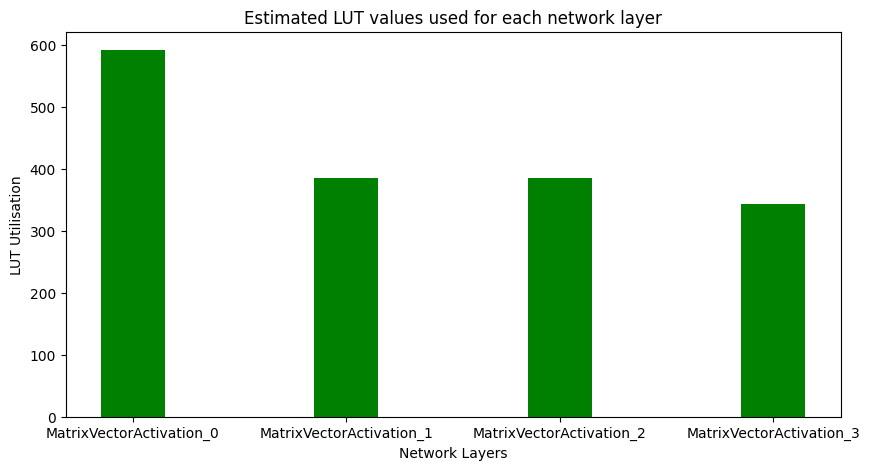

In [20]:
# Extracting LUTs from res_dict
LUTs_updated = [res_dict[key]["LUT"] for key in res_dict_updated.keys()]   

#Plotting the bar graph of each network layer with their corresponding LUT resource utilization
fig = plt.figure(figsize = (10, 5))
plt.bar(res_dict_updated.keys(), LUTs_updated, color ='green', width = 0.3)
plt.xlabel("Network Layers")
plt.ylabel("LUT Utilisation")
plt.title("Estimated LUT values used for each network layer")
plt.show()

From these numbers, we see that the first layer has been removed as the bottleneck and that the entire network can now perform one inference in ~4096 clock cycles (when the pipeline is full) as compared to the earlier configuration where it took ~38400 execution cycles.

This decrease in execution latency of the network though comes at a cost of a 45% increase in LUT resource utilization for layer 1 of the network.

We now observe the `instream_width` and `outstream_width` of our network with the updated folding parameters and then apply the `InsertDWC()` transform to it in case there is a mismatch in these widths due to the updates. 

In [21]:
fc_layers = model.get_nodes_by_op_type("MatrixVectorActivation")
for fcl in fc_layers:
    fcl_inst = getCustomOp(fcl)
    print('Instream Width =',(fcl_inst.get_instream_width()),'Outstream Width =',int(fcl_inst.get_outstream_width()))

Instream Width = 5 Outstream Width = 4
Instream Width = 2 Outstream Width = 2
Instream Width = 2 Outstream Width = 2
Instream Width = 2 Outstream Width = 1


In [22]:
model = model.transform(InsertDWC())

In [24]:
model.save("./cybsec_DWC_inserted.onnx")
showInNetron("./cybsec_DWC_inserted.onnx",localhost_url='xirxlabs53')

Stopping http://0.0.0.0:5901
Serving './cybsec_DWC_inserted.onnx' at http://0.0.0.0:5901


Because there is a mismatch in the `outstream_width` (4) of layer 1 and the `inputstream_width` (2) of layer 2 the FINN compiler inserts the `StreamingDataWidthConverter` layer to remedy this when we call that transformation for our network above.

On expanding this layer in the netron we see that the `inWidth` of this layer is 4 and the `outWidth` is 2.

Note, we do not see this insertion where these widths match. They are only mismatched for the first two layers and hence we see that the data width converter is being inserted there.

In [25]:
res_dict_DWC = []
res_dict_DWC = res_estimation(model)

['MatrixVectorActivation_0', '', 'MatrixVectorActivation_1', 'MatrixVectorActivation_2', 'MatrixVectorActivation_3']


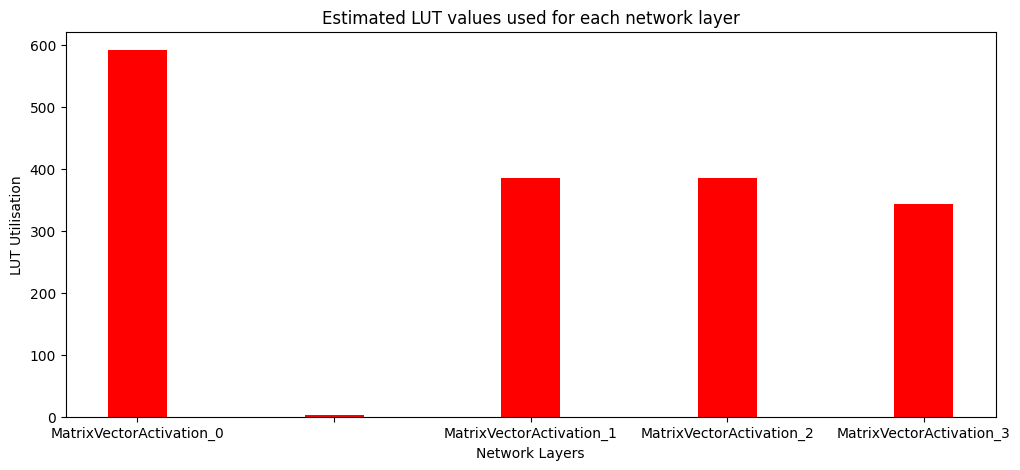

In [26]:
layers_DWC = list(res_dict_DWC.keys())
print(layers_DWC)
utilisation_DWC = list(res_dict_DWC.values())
lut_values_DWC = [] #Initializing a list to store LUT values.
for i in range(len(layers_DWC)):
    x = list(utilisation_DWC[i].values()) #Extracting the resource utilisation for each layer.
    lut_values_DWC.append(x[2]) #Extracting the LUT values of resource utilisation from each layer and appending to the list

#Plotting the bar graph of each network layer with their corresponding LUT resource utilisation
fig = plt.figure(figsize = (12, 5))
plt.bar(layers_DWC, lut_values_DWC, color ='red', width = 0.3)
plt.xlabel("Network Layers")
plt.ylabel("LUT Utilisation")
plt.title("Estimated LUT values used for each network layer")
plt.show()

The `StreamingDataWidthConverter` layer does not consume a large number of LUT resources as shown in the above graph.

<div class="alert alert-block alert-warning">
<b>Question:</b> The name of the 'StreamingDataWidthConverter' layer is not coming in the graph.
</div>

# Additional Information : Constraints table

The below table exposes the constraints associated with each layer. A developer working with these layers has to be mindful of not violating them when setting the PE & SIMD values manually.

In [ ]:
+------------------------------------+------------+----------------------------------------------------------------+
| Layers                             | Attributes | Assertions                                                     |
+====================================+============+================================================================+
| addstreams_batch                   | PE         | inp_channels % PE == 0                                         |
| channelwise_op_batch               | PE         | channels % PE == 0                                             |
| checksum                           | ~          | ~                                                              |
| concat                             | ~          | ~                                                              |
| convolutioninputgenerator          | SIMD       | inp_feature_map_channels % SIMD == 0                           |
| convolutioninputgenerator1d        | SIMD       | inp_feature_map_channels % SIMD == 0                           |
| convolutioninputgenerator_rtl      | SIMD       | inp_feature_map_channels % SIMD == 0                           |
| downsampler                        | SIMD       | inp_feature_map_channels % SIMD == 0                           |
| duplicatestreams_batch             | PE         | channels % PE == 0                                             |
| eltwise                            | PE         | inp_channels % PE == 0                                         |
| fmpadding_batch                    | SIMD       | inp_feature_map_channels % SIMD == 0                           |
| fmpadding_rtl                      | SIMD       | inp_feature_map_channels % SIMD == 0                           |
| globalaccpool_batch                | PE         | channels % PE == 0                                             |
| hlscustomop                        | ~          | ~                                                              |
| iodma                              | ~          | ~                                                              |
| labelselect_batch                  | PE         | num_labels % PE == 0                                           |
| lookup                             | ~          | ~                                                              |
| matrixvectoractivation             | PE & SIMD  | matrix_height % PE == 0 & matrix_width % SIMD == 0             |
| pool_batch                         | PE         | input_feature_map_channels % PE == 0                           |
| streamingdataflowpartition         | ~          | ~                                                              |
| streamingdatawidthconverter_batch  | ~          | ~                                                              |
| streamingfifo                      | ~          | ~                                                              |
| streamingmaxpool_batch             | ~          | ~                                                              |
| templates                          | ~          | ~                                                              |
| thresholding_batch                 | PE         | matrix_height % PE == 0                                        |
| tlastmarker                        | ~          | ~                                                              |
| upsampler                          | ~          | ~                                                              |
| vectorvectoractivation             | PE & SIMD  | kernel_height * kernel_width % SIMD == 0 & channels % PE == 0  |
+------------------------------------+------------+----------------------------------------------------------------+